# Restuarant Recommendation Chatbot Powered By AI

## Problem Statement

Create a chatbot that helps users find the perfect restaurant for any occasion. It can consider factors like cuisine preferences, dietary restrictions, location, and user reviews to make tailored recommendations.

## System Design - Diagram

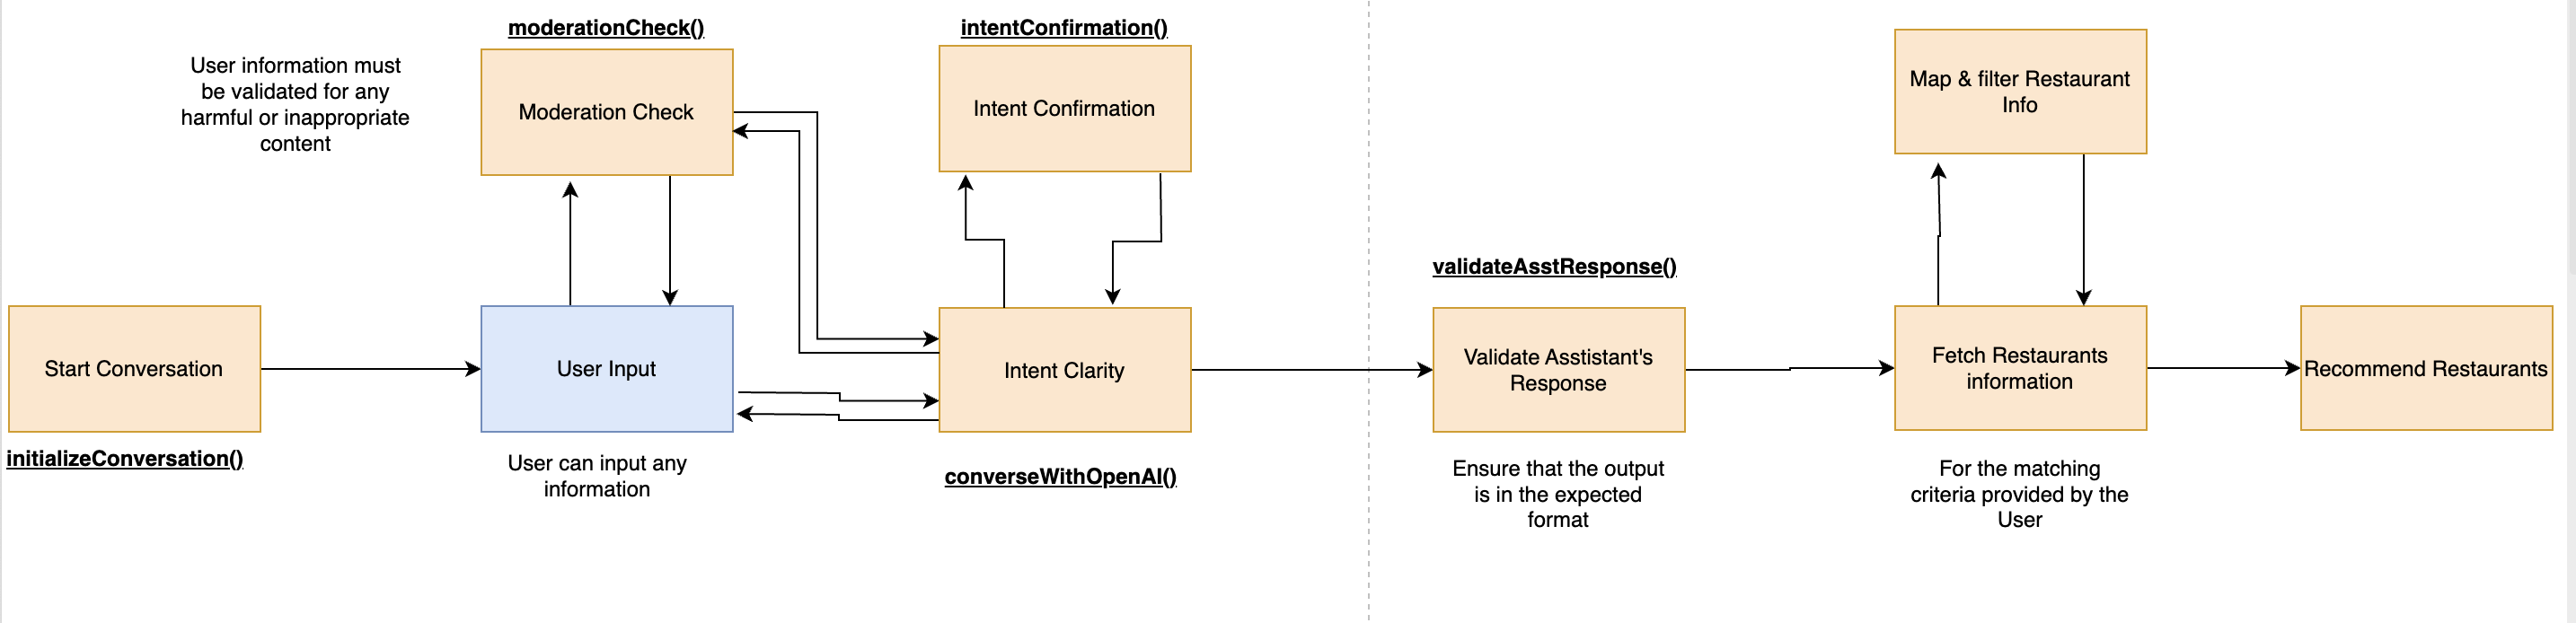

## System Design - Explained

- Start the Conversation with the user -> initializeConversation() function
- User can input any information, have checks on the input to identify any inappropriate content using open AI's moderation API endpoint -> moderationCheck() function
- Once the moderation check is completed, proceed for capturing the User Requirements - converseWithOpenAI()
- Check if the all the Requirements are captured. If yes, move to next step - intentConfirmation() function
- Pull out the Restaurant Data and map the information into Key Value pairs. These must same as the Requirements that we fetch from User.
- Once all the information is mapped, compare the User input against the available Restaurant mapped data.
- Finally, filter the Restaurants and return the top 5 restaurants based on the ratings.


### Understanding Data

In [2]:
# Import all the required Libraries
import openai
import pandas as pd
import json

In [3]:
df = pd.read_csv("restaurant_dataset.csv")

In [4]:
df.head()

,Unnamed: 0,name,rest_id,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost(for two people),listed_in(type),rating_encoded
0,0,Jalsa,1.0,Online,booking_available,4.1,775.0,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,Buffet,22.0
1,1,Spice Elephant,2.0,Online,booking_not_available,4.1,787.0,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,Buffet,22.0
2,2,San Churro Cafe,3.0,Online,booking_not_available,3.8,918.0,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,Buffet,19.0
3,3,Addhuri Udupi Bhojana,4.0,Offline,booking_not_available,3.7,88.0,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,Buffet,18.0
4,4,Grand Village,5.0,Offline,booking_not_available,3.8,166.0,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,Buffet,19.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6591 entries, 0 to 6590
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   6591 non-null   int64  
 1   name                         6591 non-null   object 
 2   rest_id                      6591 non-null   float64
 3   online_order                 6591 non-null   object 
 4   book_table                   6591 non-null   object 
 5   rate                         6591 non-null   float64
 6   votes                        6591 non-null   float64
 7   location                     6591 non-null   object 
 8   rest_type                    6591 non-null   object 
 9   dish_liked                   6591 non-null   object 
 10  cuisines                     6591 non-null   object 
 11  approx_cost(for two people)  6591 non-null   float64
 12  listed_in(type)              6591 non-null   object 
 13  rating_encoded    

In [6]:
df.describe()

,Unnamed: 0,rest_id,rate,votes,approx_cost(for two people),rating_encoded
count,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000
mean,8604.704749,3296.000000,3.892839,605.275982,759.198908,20.095737
std,5109.397530,1902.802144,0.438279,1076.021546,518.150436,4.301261
min,0.000000,1.000000,1.800000,0.000000,40.000000,1.000000
25%,4707.500000,1648.500000,3.700000,107.000000,400.000000,19.000000
50%,8237.000000,3296.000000,4.000000,229.000000,600.000000,21.000000
75%,12613.500000,4943.500000,4.200000,612.000000,1000.000000,23.000000
max,17958.000000,6591.000000,4.900000,16345.000000,4000.000000,30.000000


#### Removing Unnecessary columns and Renaming the columns to remove any spaces and special characters in the name


In [7]:
df1 = df.drop(columns=['Unnamed: 0'])

In [8]:
df1.rename(columns={'approx_cost(for two people)': 'approx_cost_for_two'}, inplace=True)

In [9]:
df1.rename(columns={'listed_in(type)': 'listed_in_type'}, inplace=True)

In [10]:
df1.rename(columns={'rate': 'rating'}, inplace=True)

In [11]:
df1.head()

,name,rest_id,online_order,book_table,rating,votes,location,rest_type,dish_liked,cuisines,approx_cost_for_two,listed_in_type,rating_encoded
0,Jalsa,1.0,Online,booking_available,4.1,775.0,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,Buffet,22.0
1,Spice Elephant,2.0,Online,booking_not_available,4.1,787.0,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,Buffet,22.0
2,San Churro Cafe,3.0,Online,booking_not_available,3.8,918.0,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,Buffet,19.0
3,Addhuri Udupi Bhojana,4.0,Offline,booking_not_available,3.7,88.0,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,Buffet,18.0
4,Grand Village,5.0,Offline,booking_not_available,3.8,166.0,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,Buffet,19.0


In [12]:
# Check for Null values
df1.isnull().sum()

name                   0
rest_id                0
online_order           0
book_table             0
rating                 0
votes                  0
location               0
rest_type              0
dish_liked             0
cuisines               0
approx_cost_for_two    0
listed_in_type         0
rating_encoded         0
dtype: int64

In [13]:
df1['rest_id'].nunique()

6591

In [14]:
df1['rest_type'].value_counts()

rest_type
Casual Dining                2112
Quick Bites                  1447
Cafe                          658
Casual Dining, Bar            307
Dessert Parlor                293
                             ... 
Fine Dining, Microbrewery       2
Dessert Parlor, Kiosk           1
Quick Bites, Food Court         1
Lounge, Cafe                    1
Dessert Parlor, Bakery          1
Name: count, Length: 68, dtype: int64

In [15]:
df1['cuisines'].value_counts()

cuisines
North Indian                                     348
North Indian, Chinese                            241
South Indian                                     108
South Indian, North Indian, Chinese               74
Ice Cream, Desserts                               73
                                                ... 
Fast Food, Burger, American                        1
Burger, Beverages, Rolls                           1
Italian, North Indian, Healthy Food, Desserts      1
Fast Food, Italian                                 1
Street Food, North Indian, Rolls                   1
Name: count, Length: 1289, dtype: int64

In [16]:
df1['listed_in_type'].value_counts()

listed_in_type
Delivery              3006
Dine-out              2197
Desserts               368
Cafes                  350
Buffet                 262
Drinks & nightlife     224
Pubs and bars          184
Name: count, dtype: int64

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6591 entries, 0 to 6590
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 6591 non-null   object 
 1   rest_id              6591 non-null   float64
 2   online_order         6591 non-null   object 
 3   book_table           6591 non-null   object 
 4   rating               6591 non-null   float64
 5   votes                6591 non-null   float64
 6   location             6591 non-null   object 
 7   rest_type            6591 non-null   object 
 8   dish_liked           6591 non-null   object 
 9   cuisines             6591 non-null   object 
 10  approx_cost_for_two  6591 non-null   float64
 11  listed_in_type       6591 non-null   object 
 12  rating_encoded       6591 non-null   float64
dtypes: float64(5), object(8)
memory usage: 669.5+ KB


- The data types look fine for all the attributes based on the data captured in each one of them

### Intialize Conversation

In [18]:
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [19]:
# Initialize API Key variable
openai.api_key = open("OPENAI_API_Key.txt", "r").read().strip("\n")

In [20]:
def initializeConversation():
    """
    This function initializes the conversation with a system message that sets the context for the AI model for restaurant recommendations.
    All the thought processes and System messages are detailed out in this function.
    Output: List: {"role": "system", "content": "System Message"}
    """
    delimiter = '####'
    sampleUserDict = {
                        "cuisine": "South Indian",
                        "restaurant_type": "Casual Dining",
                        "budget_for_two": 600,
                        "location": "Indiranagar",
                        "rating": 4.0
                      }
    
    sampleUserRequirement = {
                              "cuisine": "-",
                              "restaurant_type": "-",
                              "budget_for_two": "-",
                              "location": "-",
                              "rating": "-"
                            }
    systemMessage = f"""
    You are a restaurant recommendation system. You have access to a dataset of restaurants with the following attributes:
    - cuisine
    - restaurant_type
    - budget_for_two
    - location
    - rating
    Your goal is to help users find restaurants that match their preferences based on the above attributes.
    You need to ask the user relevant questions and understand their their preferences.
    Your final objective is to fill the values for the different keys -> ("cuisine", "restaurant_type", "budget_for_two", "location") in the user requirement dictionary and be confident of the values.
    These Key-Value pairs define the user preferences.
    User Requirement dictionary looks like below:
    {{'cuisine': 'values', 'restaurant_type': 'values', 'budget_for_two': 'values', 'location': 'values'}}

    The value for budget_for_two must be numeric value. All other values must be string.
    {delimiter}
    Here are some instructions to follow for the values of different keys:
    'rating' value must be numeric and it must be between 1.0 to 5.0
    'budget_for_two' must be numeric and it must be between 100 to 5000
    'location' can be any area available in Bangalore. You can suggest below options to the user:
    - Indiranagar
    - Koramangala
    - Jayanagar
    - MG Road
    - Whitefield
    - HSR Layout
    'cuisine' can be one of the following but note that there are many more in the dataset. You can suggest below options to the user:
    - North Indian
    - South Indian
    - Chinese
    - Italian
    - Fast Food
    - Healthy Food
    'restaurant_type' can be one of the following but note that there are many more in the dataset. You can suggest below options to the user:
    - Casual Dining 
    - Cafe
    - Quick Bites
    - Fine Dining
    {delimiter}
    To fill the sampleUserRequirement dictionary, you need to have the following chain of thoughts:
    Follow the chain of thoughts below and only output the updated sampleUserRequirement dictionary for the keys as described in {sampleUserRequirement}.\n
    {delimiter}
    Thought 1: Greet the user and ask them about their preferences for cuisine, restaurant type, budget for two, location, and rating.
    Based on the user's response, identify the corresponding keys in the sampleUserRequirement dictionary with the provided values. 
    Identify the keys for which you can fill the values confidently using the understanding. \n
    Remember the instructions around the values for the different keys.
    {delimiter}
    Thought 2: If the user does not provide all the required values, ask follow-up questions to gather the missing information.
    Ask questions you might have for all the keys to strengthen your understanding of the user's needs.
    If yes, move to the next Thought. If no, ask question on the keys whose values you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the key you want to understand value for.
    {delimiter}
    Thought 3: Check if you have correctly updated the values for the different keys in the sampleUserRequirement dictionary.
    If you are not confident about any of the values, ask clarifying questions.
    {delimiter}
    Here is an example conversation:
    User: I am looking for a place to have South Indian food in Indiranagar.
    Assistant: Great! Do you have a preference for the type of restaurant? (e.g., Casual Dining, Cafe, Quick Bites, Fine Dining)
    User: I prefer Casual Dining
    Assistant: What is your budget for two people?
    User: My budget is around 600
    Assistant: What rating do you prefer? (1.0 to 5.0)
    User: I would like a place with a rating of at least 4.0
    Assistant: Thank you for the information! Here is your updated requirement dictionary: {sampleUserDict}
    {delimiter}
    Start a conversation with the user to gather their preferences and fill the sampleUserRequirement dictionary.
    Your initial conversation should be a greeting and a question to understand user preferences. Please do not mention all the keys at once in your initial question.
    """

    return [{"role": "system", "content": systemMessage}]
    

In [21]:
examineConversation = initializeConversation()
print(examineConversation)

[{'role': 'system', 'content': '\n    You are a restaurant recommendation system. You have access to a dataset of restaurants with the following attributes:\n    - cuisine\n    - restaurant_type\n    - budget_for_two\n    - location\n    - rating\n    Your goal is to help users find restaurants that match their preferences based on the above attributes.\n    You need to ask the user relevant questions and understand their their preferences.\n    Your final objective is to fill the values for the different keys -> ("cuisine", "restaurant_type", "budget_for_two", "location") in the user requirement dictionary and be confident of the values.\n    These Key-Value pairs define the user preferences.\n    User Requirement dictionary looks like below:\n    {\'cuisine\': \'values\', \'restaurant_type\': \'values\', \'budget_for_two\': \'values\', \'location\': \'values\'}\n\n    The value for budget_for_two must be numeric value. All other values must be string.\n    ####\n    Here are some ins

In [22]:
print(examineConversation[0]['content'])


    You are a restaurant recommendation system. You have access to a dataset of restaurants with the following attributes:
    - cuisine
    - restaurant_type
    - budget_for_two
    - location
    - rating
    Your goal is to help users find restaurants that match their preferences based on the above attributes.
    You need to ask the user relevant questions and understand their their preferences.
    Your final objective is to fill the values for the different keys -> ("cuisine", "restaurant_type", "budget_for_two", "location") in the user requirement dictionary and be confident of the values.
    These Key-Value pairs define the user preferences.
    User Requirement dictionary looks like below:
    {'cuisine': 'values', 'restaurant_type': 'values', 'budget_for_two': 'values', 'location': 'values'}

    The value for budget_for_two must be numeric value. All other values must be string.
    ####
    Here are some instructions to follow for the values of different keys:
    'ratin

- Prompt looks detailed and syntax is as expected.

### Conversing with Open AI

In [23]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def converseWithOpenAI(input, jsonFormat=False):
    """
    This function takes the conversation history as input and generates a response using the OpenAI API.
    Input: List of dictionaries representing the conversation history.
    Output: String: AI-generated response. If jsonFormat is True, returns a JSON object.
    """
    model = "gpt-3.5-turbo"
    systemMessageJsonOutput = """<<. Return output in JSON format to the key output.>>"""

    if jsonFormat:
        # print("JSON Format is True")
        input[0]['content'] = input[0]['content'] + systemMessageJsonOutput
        responseFormat = {"type": "json_object"}

        chatCompletionJson = openai.chat.completions.create(
            model=model,
            messages=input,
            response_format=responseFormat,
            seed=2345
        )

        output = json.loads(chatCompletionJson.choices[0].message.content)

    else:
        # print("JSON Format is False")
        chatCompletion = openai.chat.completions.create(
            model=model,
            messages=input,
            seed=3456
        )

        output = chatCompletion.choices[0].message.content
    return output

In [24]:
inputPrompt = "which is the fastest proessor in the world currently?"
messages = [{"role": "user", "content": inputPrompt}]
messages

[{'role': 'user',
  'content': 'which is the fastest proessor in the world currently?'}]

In [25]:
converseWithOpenAI(messages)

'As of September 2021, the AMD Ryzen 9 5950X processor is considered one of the fastest consumer processors available on the market.'

In [26]:
inputPrompt = "which is the strongest metal on earth? Artificial and/or naturally occuring?"
messages = [{"role": "user", "content": inputPrompt}]
converseWithOpenAI(messages)

'The strongest naturally occurring metal on Earth is tungsten, with a tensile strength of 1510 MPa. \n\nWhen it comes to artificial metals, carbon nanotubes are considered to be the strongest material known to man. They have an estimated tensile strength of 63 GPa, which is over 40 times stronger than the strongest naturally occurring metal.'

- Sample Conversation with the AI is working as expected.

### Moderation Check 

In [27]:
def moderationCheck(inputText):
    """
    This function checks the input text for any content that violates OpenAI's content policy using the Moderation API.
    Input: String: Text to be checked.
    Output: Returns "Flagged" if the content is inappropriate, otherwise returns "Not Flagged".
    """
    response = openai.moderations.create(
        model="omni-moderation-latest",
        input=inputText
    )
    if response.results[0].flagged:
        return "Flagged"
    else:
        return "Not Flagged"

In [28]:
inputPrompt = "I want all the humans to be erased on the planet"
messages = [{"role": "user", "content": inputPrompt}]
moderationCheck(inputPrompt)

'Flagged'

In [29]:
inputPrompt = "I want a killer cell phone"
messages = [{"role": "user", "content": inputPrompt}]
moderationCheck(inputPrompt)

'Not Flagged'

In [30]:
inputPrompt = "I want to learn how to make a bomb"
messages = [{"role": "user", "content": inputPrompt}]
moderationCheck(inputPrompt)

'Flagged'

- Moderation Check is working as expected. Harmful content is being flagged

### Intent Confirmation

In [31]:
def intentConfirmation(assistantResponse):
    """
    This function is used to confirm if the required information has been correctly understood by the AI model.
    If the information is not complete, the function returns "No" along with proper justification. Otherwise, it returns "Yes" with a Json object.
    """
    delimiter = '####'
    prompt = f""" 
    You are an expert evaluator who can validate if the information provided is complete and accurate. 
    The input text will contain the information captured using five keys. Your task is to evaulate the input and ensure if it has the following keys with valid values:
    {{
        "cuisine": "values",
        "restaurant_type": "values",
        "budget_for_two": 'numeric_value',
        "location": "values",
        "rating": 'numeric_value'
    }}
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Output "Yes" if all the keys are present with valid values. If any key is missing or has an invalid value, output "No" along with a justification.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'. Make sure the reason is specific and points to the exact key which is incorrectly filled.
    Thought 3 - Think carefully before the answering.
    """
    messages = [
                {"role": "system", "content": prompt},
                {"role": "user", "content": f"Here is the input information: {assistantResponse}"}
                ]
    responseFormat = {"type": "json_object"}
    response = openai.chat.completions.create(
                                                model="gpt-3.5-turbo",
                                                messages=messages,
                                                response_format=responseFormat,
                                                seed=4567
                                            )
                                            
    jsonOutput = json.loads(response.choices[0].message.content)
    return jsonOutput

In [32]:
intentConfirmationEx1 = f"""
Thank you for providing all the information. Here are your preferences for a restaurant:
{{"cuisine": "South Indian", 
     "restaurant_type": "Casual Dining", 
     "budget_for_two": 600, 
     "location": "Indiranagar", 
     "rating": 4.0
}}
"""

In [33]:
intentConfirmation(intentConfirmationEx1)

{'result': 'Yes'}

In [34]:
intentConfirmationEx2 = f"""
Thank you for providing all the information. Here are your preferences for a restaurant:
{{"cuisine": "South Indian", 
     "restaurant_type": "Casual Dining", 
     "budget_for_two": 600, 
     "rating": 4.0
}}
"""
intentConfirmation(intentConfirmationEx2)

{'result': 'No',
 'reason': "The 'location' key is missing in the input information."}

In [35]:
intentConfirmationEx3 = f"""
Thank you for providing all the information. Here are your preferences for a restaurant:
{{"cuisine": "South Indian", 
     "restaurant_type": "Casual Dining", 
     "rating": 4.0
}}
"""
intentConfirmation(intentConfirmationEx3)

{'result': 'No',
 'reason': "Missing keys and values. 'budget_for_two' and 'location' keys are missing with invalid values."}

- Intent Confirmation is working as expected for both positive and negative cases

### Validate AI Assistant's Response

In [36]:
def validateAsstResponse(assistantResponse):
    """
    
    """
    delimiter = '####'
    userInput = {
                "cuisine": "South Indian",
                "restaurant_type": "Casual Dining",
                "budget_for_two": 600,
                "location": "Indiranagar",
                "rating": 4.0
                }
    prompt = f""" 
    You are an expert in Python Programming. You are provided an input & your task is to check if a Python dictionary is present or not.
    If the provided input does not contain a Python dictionary, your task is to extract the relavant information from the input text and create a Python dictionary in the Json format.
    Return only the python dictionary in JSON format as output.
    The output must match the format {userInput}.
    {delimiter}
    Make sure that the value of budget_for_two is also present in the user input. ###
    The output should contain the exact keys and values as present in the input.
    Ensure the keys and values are in the given format:
    {{
    "cuisine": "values",
    "restaurant_type": "values",
    "budget_for_two": "values",
    "location": "values",
    "rating": "values"
    }}
    """
    messages = [
                {"role": "system", "content": prompt},
                {"role": "user", "content": f"Here is the input information: {assistantResponse}"}
                ]    
    jsonOutput = converseWithOpenAI(messages, jsonFormat=True)
    # print("JSON Output from validateAsstResponse function:", jsonOutput)
    # print("Type of JSON Output:", type(jsonOutput))

    return jsonOutput
    

- Validate the output from the above function

In [37]:
responseEx1 = {
     "cuisine": "North Indian", 
     "restaurant_type": "Quick Bites", 
     "budget_for_two": 300, 
     "location": "Koramanagala", 
     "rating": 4.5
}

In [38]:
asstResponseOutput = validateAsstResponse(responseEx1)
print(asstResponseOutput)

{'cuisine': 'North Indian', 'restaurant_type': 'Quick Bites', 'budget_for_two': 300, 'location': 'Koramanagala', 'rating': 4.5}


In [39]:
responseEx2 = """Based on your preferences, here is a summary of your restaurant requirements:
cuisine - Italian
restaurant_type - Fine Dining
budget_for_two - 1500,     
location - MG Road
rating - 4.2
"""
asstResponseOutput = validateAsstResponse(responseEx2)
print(asstResponseOutput)


{'cuisine': 'Italian', 'restaurant_type': 'Fine Dining', 'budget_for_two': 1500, 'location': 'MG Road', 'rating': 4.2}


- validateAsstResponse is working as expected for both positive and negative test cases

### Consistency Testing

In [40]:
def consistencyTesting(inputFunction, inputResponse, iterations=10):
    """
    This function is used to test the consistency of the validateAsstResponse function.
    It runs multiple iterations of the function with the same input and checks if the output is consistent.
    Input: Function: The function to be tested.
           String/Dict: The input to be provided to the function.
    Output: Boolean: True if the output is consistent, False otherwise.
    """
    outputs = []
    for i in range(iterations):
        output = inputFunction(inputResponse)
        outputs.append(json.dumps(output, sort_keys=True))
        print("*"*50)
        print(f"Iteration:{i + 1}")
        print(output)
        print("*"*50)
    
    if all(x == outputs[0] for x in outputs):
        return True
    else:
        return False

In [41]:
consistencyFlag = consistencyTesting(validateAsstResponse, responseEx1)
if consistencyFlag:
    print("The function is consistent.")
else:
    print("The function is not consistent.")

**************************************************
Iteration:1
{'cuisine': 'North Indian', 'restaurant_type': 'Quick Bites', 'budget_for_two': 300, 'location': 'Koramanagala', 'rating': 4.5}
**************************************************
**************************************************
Iteration:2
{'cuisine': 'North Indian', 'restaurant_type': 'Quick Bites', 'budget_for_two': 300, 'location': 'Koramanagala', 'rating': 4.5}
**************************************************
**************************************************
Iteration:3
{'cuisine': 'North Indian', 'restaurant_type': 'Quick Bites', 'budget_for_two': 300, 'location': 'Koramanagala', 'rating': 4.5}
**************************************************
**************************************************
Iteration:4
{'cuisine': 'North Indian', 'restaurant_type': 'Quick Bites', 'budget_for_two': 300, 'location': 'Koramanagala', 'rating': 4.5}
**************************************************
********************************

In [42]:
consistencyFlag = consistencyTesting(validateAsstResponse, responseEx2)
if consistencyFlag:
    print("The function is consistent.")
else:
    print("The function is not consistent.")

**************************************************
Iteration:1
{'cuisine': 'Italian', 'restaurant_type': 'Fine Dining', 'budget_for_two': 1500, 'location': 'MG Road', 'rating': 4.2}
**************************************************
**************************************************
Iteration:2
{'cuisine': 'Italian', 'restaurant_type': 'Fine Dining', 'budget_for_two': 1500, 'location': 'MG Road', 'rating': 4.2}
**************************************************
**************************************************
Iteration:3
{'cuisine': 'Italian', 'restaurant_type': 'Fine Dining', 'budget_for_two': 1500, 'location': 'MG Road', 'rating': 4.2}
**************************************************
**************************************************
Iteration:4
{'cuisine': 'Italian', 'restaurant_type': 'Fine Dining', 'budget_for_two': 1500, 'location': 'MG Road', 'rating': 4.2}
**************************************************
**************************************************
Iteration:5
{'cui

- As per the above examples, the output is consistent from the Assistant. The consistency testing is successful.

### System Testing - Part 1

In [43]:
converseWithAsst = initializeConversation()
userPrompt = "Hi, I am looking for a place to have Italian food in MG Road."
validateModerationCheck = moderationCheck(userPrompt)
print("Moderation Check:", validateModerationCheck)
converseWithAsst.append({"role": "user", "content": userPrompt})
validateResponse = converseWithOpenAI(converseWithAsst)
print("Validation of Asst Response:", validateResponse)
validateModerationCheck = moderationCheck(validateResponse)
print("Moderation Check of Asst's Response:", validateModerationCheck)
converseWithAsst.append({"role": "assistant", "content": validateResponse})
validateIntentConfirmation = intentConfirmation(validateResponse)
finalResponse = validateAsstResponse(responseEx2)
print("Final Response from the Assistant:", finalResponse)



Moderation Check: Not Flagged
Validation of Asst Response: Assistant: Great choice! Do you have a preference for the type of restaurant? (e.g., Casual Dining, Cafe, Quick Bites, Fine Dining)
Moderation Check of Asst's Response: Not Flagged
Final Response from the Assistant: {'cuisine': 'Italian', 'restaurant_type': 'Fine Dining', 'budget_for_two': 1500, 'location': 'MG Road', 'rating': 4.2}


### Update Database With A New Feature

In [44]:
def mapNewFeatureToDatabase(allFeatures):
    """
    This function maps a new feature to the existing database.
    Input: DataFrame: The existing database.
    Output: DataFrame: The updated database with the new feature.
    """
    return {
            "cuisine": allFeatures.split(":")[0],
            "restaurant_type": allFeatures.split(":")[1],
            "budget_for_two": float(allFeatures.split(":")[2]),
            "location": allFeatures.split(":")[3],
            "rating": float(allFeatures.split(":")[4])
            }

In [45]:
df1['restaurant_features'] = df1['cuisines'] + ":" + df1['rest_type'] + ":" + df1['approx_cost_for_two'].astype(str) + ":" + df1['location'] + ":" + df1['rating'].astype(str)
df1['mapped_features'] = df1['restaurant_features'].apply(mapNewFeatureToDatabase)
df1.head()

,name,rest_id,online_order,book_table,rating,votes,location,rest_type,dish_liked,cuisines,approx_cost_for_two,listed_in_type,rating_encoded,restaurant_features,mapped_features
0,Jalsa,1.0,Online,booking_available,4.1,775.0,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,Buffet,22.0,"North Indian, Mughlai, Chinese:Casual Dining:8...","{'cuisine': 'North Indian, Mughlai, Chinese', ..."
1,Spice Elephant,2.0,Online,booking_not_available,4.1,787.0,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,Buffet,22.0,"Chinese, North Indian, Thai:Casual Dining:800....","{'cuisine': 'Chinese, North Indian, Thai', 're..."
2,San Churro Cafe,3.0,Online,booking_not_available,3.8,918.0,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,Buffet,19.0,"Cafe, Mexican, Italian:Cafe, Casual Dining:800...","{'cuisine': 'Cafe, Mexican, Italian', 'restaur..."
3,Addhuri Udupi Bhojana,4.0,Offline,booking_not_available,3.7,88.0,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,Buffet,18.0,"South Indian, North Indian:Quick Bites:300.0:B...","{'cuisine': 'South Indian, North Indian', 'res..."
4,Grand Village,5.0,Offline,booking_not_available,3.8,166.0,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,Buffet,19.0,"North Indian, Rajasthani:Casual Dining:600.0:B...","{'cuisine': 'North Indian, Rajasthani', 'resta..."


In [46]:
pd.set_option('display.max_colwidth', None)  # Ensure full column values are displayed
display(df1['mapped_features'].head(10))    # Display the first 10 rows of the 'mapped_features' column

0     {'cuisine': 'North Indian, Mughlai, Chinese', 'restaurant_type': 'Casual Dining', 'budget_for_two': 800.0, 'location': 'Banashankari', 'rating': 4.1}
1        {'cuisine': 'Chinese, North Indian, Thai', 'restaurant_type': 'Casual Dining', 'budget_for_two': 800.0, 'location': 'Banashankari', 'rating': 4.1}
2       {'cuisine': 'Cafe, Mexican, Italian', 'restaurant_type': 'Cafe, Casual Dining', 'budget_for_two': 800.0, 'location': 'Banashankari', 'rating': 3.8}
3           {'cuisine': 'South Indian, North Indian', 'restaurant_type': 'Quick Bites', 'budget_for_two': 300.0, 'location': 'Banashankari', 'rating': 3.7}
4           {'cuisine': 'North Indian, Rajasthani', 'restaurant_type': 'Casual Dining', 'budget_for_two': 600.0, 'location': 'Basavanagudi', 'rating': 3.8}
5                       {'cuisine': 'North Indian', 'restaurant_type': 'Casual Dining', 'budget_for_two': 600.0, 'location': 'Basavanagudi', 'rating': 3.8}
6         {'cuisine': 'Pizza, Cafe, Italian', 'restaurant_type':

### Compare User Input With Mapped Features

In [47]:
def filterRestaurants(userPreferences, df1):
    """
    This function filters the restaurants based on user preferences.
    Input: Dict: The user preferences.
    Output: DataFrame: The filtered restaurants.
    """
    filteredDF = df1.copy()
    
    if userPreferences['cuisine'] != "-":
        filteredDF = filteredDF[filteredDF['cuisines'].str.contains(userPreferences['cuisine'], case=False, na=False)]
        # print(f"Number of restaurants after filtering by cuisine ({userPreferences['cuisine']}): {len(filteredDF)}")
    
    if userPreferences['restaurant_type'] != "-":
        filteredDF = filteredDF[filteredDF['rest_type'].str.contains(userPreferences['restaurant_type'], case=False, na=False)]
        # print(f"Number of restaurants after filtering by restaurant type ({userPreferences['restaurant_type']}): {len(filteredDF)}")
    
    if userPreferences['budget_for_two'] != "-":
        budget = float(userPreferences['budget_for_two'])
        filteredDF = filteredDF[filteredDF['approx_cost_for_two'] <= budget]
        # print(f"Number of restaurants after filtering by budget for two (<= {budget}): {len(filteredDF)}")
    
    if userPreferences['location'] != "-":
        filteredDF = filteredDF[filteredDF['location'].str.contains(userPreferences['location'], case=False, na=False)]
        # print(f"Number of restaurants after filtering by location ({userPreferences['location']}): {len(filteredDF)}")
    
    if userPreferences['rating'] != "-":
        rating = float(userPreferences['rating'])
        filteredDF = filteredDF[filteredDF['rating'] >= rating]
        # print(f"Number of restaurants after filtering by rating (>= {rating}): {len(filteredDF)}")
    
    return filteredDF[['name', 'rating']]

In [48]:
sampleTestUserPreference1 = {
    'cuisine': 'North Indian',
    'restaurant_type': 'Quick Bites',
    'budget_for_two': 100,
    'location': 'Indiranagar',
    'rating': 3.5
}

In [49]:
print(filterRestaurants(sampleTestUserPreference1, df1))

                          name  rating
1953  Srinidhi Sagar Food Line     3.7
5570  Srinidhi Sagar Food Line     3.7


In [50]:
sampleTestUserPreference2 = {
    'cuisine': 'South Indian',
 'restaurant_type': 'Casual Dining',
 'budget_for_two': 1000,
 'location': 'Indiranagar',
 'rating': 3.5
}
print(filterRestaurants(sampleTestUserPreference2, df1))

                                       name  rating
2042                          Gokul Kuteera     3.9
2052                        Coastal Delight     4.1
2060  Meaza Ginger Multi Cuisine Restaurant     3.6
2071                            Aagaman Veg     4.0
4826                          Gokul Kuteera     3.9
5576                     Asaivam Restaurant     4.0
6330                            Southindies     4.1
6333                      Empire Restaurant     4.2
6335                            Aagaman Veg     4.0
6340                            Annapoorani     3.9
6439                 Dindigul Thalappakatti     4.3
6530                            Aagaman Veg     4.0
6575                               Anjappar     3.8


In [51]:
sampleTestUserPreference3 = {
    'cuisine': 'Chinese',
 'restaurant_type': 'Casual Dining',
 'budget_for_two': 700,
 'location': 'Banashankari',
 'rating': 3.5
}
print(filterRestaurants(sampleTestUserPreference3, df1))

                name  rating
27   Szechuan Dragon     4.2
62      Anna Kuteera     4.0
125   Green Gardenia     3.8
198    Swadesh Tadka     3.5
263     Anna Kuteera     4.0
264  Szechuan Dragon     4.2
278   Green Gardenia     3.8
283    Swadesh Tadka     3.5


In [52]:
def recommendRestaurants(userPreferences, df1, topN=5):
    """
    This function recommends top N restaurants based on user preferences.
    Input: Dict: The user preferences.
           DataFrame: The existing database.
           Int: The number of top restaurants to recommend.
    Output: DataFrame: The recommended restaurants.
    """
    filteredDF = filterRestaurants(userPreferences, df1)
    # emptyFlag
    
    if filteredDF.empty:
        return None
    
    filteredDF = filteredDF.sort_values(by='rating', ascending=False)
    recommendedDF = filteredDF.head(topN)
    
    return recommendedDF

In [53]:
def endUserConversationWithAI():
    conversation = initializeConversation()
    introduction = converseWithOpenAI(conversation)
    # print(introduction)
    top_5_recommendations = None
    userInput ="" 

    while userInput != "exit":
        userInput = input("Enter your message (or type 'exit' to quit): ")

        moderationCheckFlag = moderationCheck(userInput)
        if moderationCheckFlag == "Flagged":
            print("Your input has been flagged by the moderation system. Please avoid inappropriate content. Please restart the conversation.")
            break 

        if top_5_recommendations is None:
            print("User: ", userInput)
            conversation.append({"role": "user", "content": userInput})
            assistantResponse = converseWithOpenAI(conversation)
            print("Assistant: ", assistantResponse)

            moderationCheckFlag = moderationCheck(assistantResponse)
            if moderationCheckFlag == "Flagged":
                print("The assistant's response has been flagged by the moderation system. Please avoid inappropriate content. Please restart the conversation.")
                break

            intentConfirmationResponse = intentConfirmation(assistantResponse)
            print("Intent Confirmation Message:", intentConfirmationResponse)

            if intentConfirmationResponse['result'] == "Yes":
                print("Thank you!. All the required information has been captured.")
                print("Recommending top 5 restaurants based on your preferences...")
                validatedResponse = validateAsstResponse(assistantResponse)
                # print("Validated Response:", validatedResponse)
                # print("Type of Validated Response:", type(validatedResponse))
                top_5_recommendations = recommendRestaurants(validatedResponse, df1, topN=5)
                if top_5_recommendations is None or top_5_recommendations.empty:
                    print("*"*50)
                    print("No restaurants found matching your preferences. Please try again with different preferences.")
                    print("*"*50)
                    break
                print("*"*50)
                print("Top 5 Restaurant Recommendations based on your preferences:")
                print(top_5_recommendations)
                print("*"*50)
                break

In [54]:
endUserConversationWithAI()

User:  hi, looking for a restaurant
Assistant:  Hello! I'd be happy to help you find a restaurant. Could you please let me know what type of cuisine you are in the mood for today?
Intent Confirmation Message: {'result': 'No', 'reason': 'Missing keys'}
User:  italian
Assistant:  Great choice! Do you have any preference for the type of restaurant? (e.g., Casual Dining, Cafe, Quick Bites, Fine Dining)
Intent Confirmation Message: {'result': 'No', 'reason': 'Missing key: cuisine'}
User:  fine dining
Assistant:  What is your budget for two people?
Intent Confirmation Message: {'result': 'No', 'reason': 'Missing keys: cuisine, restaurant_type, location, rating. Invalid key: budget_for_two'}
User:  300
Assistant:  What location are you looking to dine in?
Intent Confirmation Message: {'result': 'No', 'reason': 'Missing keys: cuisine, restaurant_type, budget_for_two, location, rating'}
User:  indiranagar
Assistant:  What rating do you prefer? (1.0 to 5.0)
Intent Confirmation Message: {'result'

In [55]:
endUserConversationWithAI()

User:  hi, looking to have food outside
Assistant:  Hello! That's great to hear. 
What type of cuisine are you in the mood for today?
Intent Confirmation Message: {'result': 'No', 'reason': 'Missing keys'}
User:  south indian
Assistant:  Great! Do you have a preference for the type of restaurant? (e.g., Casual Dining, Cafe, Quick Bites, Fine Dining)
Intent Confirmation Message: {'result': 'No', 'reason': 'Missing keys'}
User:  looking for casual dining
Assistant:  What is your budget for two people?
Intent Confirmation Message: {'result': 'No', 'reason': 'Missing keys: cuisine, restaurant_type, location, rating. Invalid key: budget_for_two'}
User:  casual dining
Assistant:  What is your budget for two people?
Intent Confirmation Message: {'result': 'No', 'reason': 'Missing keys: cuisine, restaurant_type, location, rating. Invalid key: budget_for_two'}
User:  koramangala
Assistant:  What is your budget for two people?
Intent Confirmation Message: {'result': 'No', 'reason': 'Missing keys